In [28]:
# un comment this if code dependencies fail
# !apt-get update > /dev/null 2>&1
# !pip install ez_setup > /dev/null 2>&1
# !pip install gym[atari] > /dev/null 2>&1
# !pip install --upgrade setuptools 2>&1
# !apt-get install cmake > /dev/null 2>&1

In [2]:
import numpy as np
import seaborn as sns
from pylab import rcParams
import sys
import matplotlib.pyplot as plt
import gym
# from matplotlib import rc
from contextlib import closing
from io import StringIO
from gym import utils
from gym.envs.toy_text import discrete
import time
from IPython.display import clear_output
import scipy
from tqdm.notebook import tqdm
import time
from collections import defaultdict
from scipy.signal import savgol_filter

start_time = time.time()
%matplotlib inline
rcParams['figure.figsize'] = 20, 12
sns.set(style='whitegrid', font_scale=1.2, palette='deep')
np.random.seed(44)

# Setting up the environment

In [3]:
# MAP = [                
#     "+---------+",
#     "|R: :A: :G|",
#     "| : : : : |",
#     "| :A:A: : |",
#     "| : : : : |",
#     "|Y: :A:B: |",
#     "+---------+",
# ]

MAP = [
    "+-----------------+",
    "|R: :X: : : :X: :G|",
    "| : : : :X: : : : |",
    "|X:X: : :X: : :X:X|",
    "| : : : : : : : : |",
    "| :X:X: : : :X:X: |",
    "| : : : : : : : : |",
    "| : : : :X: : : : |",
    "| : : : :X: : : : |",
    "|Y: :X: : : :X: :B|",
    "+-----------------+",
]


class CustomCab(discrete.DiscreteEnv):
    """
    This is a Modified Taxi Problem from Open AI gym

    Description:
    There are 4 locations indicated by R, B, G, & Y. 
    Each episode begins with a random taxi squre and the passenger is at a random location. 
    The goal is for taxi to pick up passenger and dropp of passenger at the right location in least time without hitting barriers (denoted with X)
    The episode ends if the taxi hit a Wall(X) or one the passenger is dropped off

    State Space: 
    9x9 taxi positions
    5 possible passenger location (R, G, B, Y, Onboard)
    4 possible destination (R, G, B, Y)
    
    total number of states = 9x9x5x4 = 1620 states
    
    Actions: 
    There are 6 discrete deterministic actions:
    - 0: move up
    - 1: move down
    - 2: move left 
    - 3: move right 
    - 4: pickup passenger
    - 5: dropoff passenger
    
    Rewards: 
    -1 for each action
    +1000 for delievering the passenger. 
    -10 for illegal pickup/dropoff
    -1000 for hitting the wall(X)

    Rendering:
    - green: full taxi
    - blue: passenger
    - red: anomaly
    - magenta: destination
    - yellow: empty taxi
    - other letters (R, G, B and Y): locations for passengers and destinations

    actions:
    - 0: down
    - 1: left
    - 2: up
    - 3: down
    - 4: pickup
    - 5: dropoff

    the state space is represented by:
        (taxi_row, taxi_col, passenger_loc, destination)
    """
    metadata = {'render.modes': ['human', 'ansi']}

    def __init__(self):
        self.desc = np.asarray(MAP, dtype='c')

        self.locs = locs = [(0,0), (0,8), (8,0), (8,8)]
        self.anomaly_locs = [(0,2), (0,6), (1,4), (2,0), (2,1), (2,4), (2,7), (2,8), (4,1), (4,2), (4,6), (4,7), (6,4), (7,4), (8,2), (8,6)]

        self.num_rows = 9
        self.num_columns = 9
        self.num_states = self.num_rows * self.num_columns * len(self.locs) * (len(self.locs) + 1)

        state_distribution = np.zeros(self.num_states)
        num_actions = 6
#         P = {state: {action: []
#                      for action in range(num_actions)} for state in range(self.num_states)}
        P = defaultdict(lambda: defaultdict(list))
        for row in range(self.num_rows):
            for col in range(self.num_columns):
                for pass_idx in range(len(self.locs) + 1):  # +1 for being inside taxi
                    for dest_idx in range(len(self.locs)):
                        state = self.encode(row, col, pass_idx, dest_idx)
                        if pass_idx != dest_idx and pass_idx <= 3:
                            state_distribution[state] += 1
                        for action in range(num_actions):
                            new_row, new_col, new_pass_idx = row, col, pass_idx
                            reward = -1   # default reward
                            done = False
                            taxi_loc = (row, col)

                            if action == 0:
                                new_row = min(row + 1, self.num_rows - 1)
                            elif action == 1:
                                new_row = max(row - 1, 0)
                            elif action == 2:
                                new_col = min(col + 1, self.num_columns - 1)
                            elif action == 3:
                                new_col = max(col - 1, 0)
                            elif action == 4:  # pickup
                                if (pass_idx <= 3 and taxi_loc == locs[pass_idx]):
                                    new_pass_idx = 4
                                else: # illegal pickup
                                    reward = -10
                            elif action == 5:  # dropoff
                                if (taxi_loc == locs[dest_idx]) and pass_idx == 4:
                                    new_pass_idx = dest_idx
                                    done = True
                                    reward = 1000
                                elif (taxi_loc in locs) and pass_idx == 4:
                                    new_pass_idx = locs.index(taxi_loc)
                                else: # illegal dropoff
                                    reward = -10
                                    
                            if (new_row, new_col) in self.anomaly_locs \
                                or new_row < 0 or new_row >= self.num_rows \
                                or new_col < 0 or new_col >= self.num_columns:
                                
                                done = True  
                                reward = -1000

                            new_state = self.encode(new_row, new_col, new_pass_idx, dest_idx)
                            P[state][action].append((1.00, new_state, reward, done))
        state_distribution /= state_distribution.sum()
        discrete.DiscreteEnv.__init__(
            self, self.num_states, num_actions, P, state_distribution)

    def encode(self, taxi_row, taxi_col, pass_loc, dest_idx):
        # (9) 9, 5, 4
        i = taxi_row
        i *= self.num_columns
        i += taxi_col
        i *= (len(self.locs) + 1)
        i += pass_loc
        i *= (len(self.locs))
        i += dest_idx
        return i

    def decode(self, i):
        out = []
        out.append(i % len(self.locs))
        i = i // len(self.locs)
        out.append(i % (len(self.locs)+1))
        i = i // (len(self.locs)+1)
        out.append(i % self.num_rows)
        i = i // self.num_rows
        out.append(i)

        if i < 0 or i >= self.num_rows:
            raise Exception('Error in decoding')

        return reversed(out)

    def render(self, mode='human'):
        outfile = StringIO() if mode == 'ansi' else sys.stdout

        out = self.desc.copy().tolist()
        out = [[c.decode('utf-8') for c in line] for line in out]
        taxi_row, taxi_col, pass_idx, dest_idx = self.decode(self.s)
        
        def ul(x): return "_" if x == " " else x
        
        if pass_idx < 4:
            out[1 + taxi_row][2 * taxi_col + 1] = utils.colorize(
                out[1 + taxi_row][2 * taxi_col + 1], 'yellow', highlight=True)
            pi, pj = self.locs[pass_idx]
            out[1 + pi][2 * pj + 1] = utils.colorize(out[1 + pi][2 * pj + 1], 'blue', bold=True)
        else:  # passenger in taxi
            out[1 + taxi_row][2 * taxi_col + 1] = utils.colorize(
                ul(out[1 + taxi_row][2 * taxi_col + 1]), 'green', highlight=True)

        di, dj = self.locs[dest_idx]
        out[1 + di][2 * dj + 1] = utils.colorize(out[1 + di][2 * dj + 1], 'magenta')
        
        for (zx, zy) in self.anomaly_locs:
          out[1 + zx][2 * zy + 1] = utils.colorize(
            out[1 + zx][2 * zy + 1], 'red', bold=True)
        
        outfile.write("\n".join(["".join(row) for row in out]) + "\n")
        if self.lastaction is not None:
            outfile.write("  ({})\n".format(["South", "North", "East", "West", "Pickup", "Dropoff"][self.lastaction]))
        else: outfile.write("\n")

        # No need to return anything for human
        if mode != 'human':
            with closing(outfile):
                return outfile.getvalue()
              
gym.envs.registration.register(
    id='CustomCab-v0',
    entry_point=f"{__name__}:CustomCab")

In [4]:
def show_frames(frames):
  for frame in frames:
    clear_output(wait=True)
    print(frame['frame'])
    print(f"Episode: {frame['episode']}")
    print(f"Timestep: {frame['step']}")    
    print(f"State: {frame['state']}")
    print(f"Reward: {frame['reward']}")
    time.sleep(0.1)

In [5]:
env = gym.make('CustomCab-v0')

In [6]:
env.reset()
env.render()

print("Action Space {}".format(env.action_space))
print("State Space {}".format(env.observation_space))

+-----------------+
|R: :X: : : :X: :G|
| : : : :X: : : : |
|X:X: : :X: : :X:X|
| : : : : : : : : |
| :X:X: : : :X:X: |
| : : : : : : : : |
| : : : :X: : : : |
| : : : :X: : : : |
|Y: :X: : : :X: :B|
+-----------------+

Action Space Discrete(6)
State Space Discrete(1620)


# Q-Learning agent

In [7]:
class Q_LearningAgent:
  
    def __init__(self, n_states, n_actions, decay_rate=0.0001, learning_rate=0.71, gamma=0.62):
        self.n_actions = n_actions
        self.q_table = np.zeros((n_states, n_actions))
        self.epsilon, self.max_epsilon, self.min_epsilon = 1.0, 1.0, 0.001
        self.epsilons_ = list()
        self.decay_rate, self.learning_rate, self.gamma = decay_rate, learning_rate, gamma

    def choose_action(self, state, explore=True):
        exploration_tradeoff = np.random.uniform(0, 1)

        if exploration_tradeoff < self.epsilon and explore:
            return np.random.randint(self.n_actions)    
        else:
            return np.argmax(self.q_table[state, :])

    def learn(self, state, action, reward, next_state, done, episode):
        self.q_table[state, action] = self.q_table[state, action] + self.learning_rate * (reward + self.gamma * np.max(self.q_table[next_state, :]) - self.q_table[state, action])

        if done:
            self.epsilon = self.min_epsilon + (self.max_epsilon - self.min_epsilon) * np.exp(-self.decay_rate * episode)
            self.epsilons_.append(self.epsilon)

    def train(self, env, total_episodes, show_progress=True):
        rewards = list()
        for episode in tqdm(range(total_episodes), disable= not show_progress):
            state = env.reset()
            episode_rewards = list()

            while True:

                action = self.choose_action(state)
                new_state, reward, done, info = env.step(action)
                self.learn(state, action, reward, new_state, done, episode)
                state = new_state
                episode_rewards.append(reward)

                if done:
                  break

            rewards.append(np.mean(episode_rewards))
        return rewards
    
    def evaluate(self, env, total_test_episodes, show_progress=True):
        frames = list()
        rewards = list()
        for episode in tqdm(range(total_test_episodes), disable=not show_progress):
            state = env.reset()
            episode_rewards = list()
            step = 1

            while True:
                action = self.choose_action(state, explore=False)
                new_state, reward, done, info = env.step(action)        
                frames.append({
                  'frame': env.render(mode='ansi'), 'state': state,
                  'episode': episode + 1, 'step': step, 'reward': reward
                })

                episode_rewards.append(reward)
                if done:
                    step = 0
                    break
                state = new_state
                step += 1

            rewards.append(np.mean(episode_rewards))
        env.close()
        return rewards, frames
        

# SARSA Agent

In [8]:
class SARSA_Agent(Q_LearningAgent):
    def learn(self, state, action, reward, next_state, next_action, done, episode):
        self.q_table[state, action] = self.q_table[state][action] + self.learning_rate*(reward + self.gamma*self.q_table[next_state][next_action] - self.q_table[state][action])

        if done:
          self.epsilon = self.min_epsilon + (self.max_epsilon - self.min_epsilon) * np.exp(-self.decay_rate * episode)
          self.epsilons_.append(self.epsilon)

    def train(self, env, total_episodes):
        rewards = list()
        for episode in tqdm(range(total_episodes)):
            state = env.reset()
            episode_rewards = list()

            action = self.choose_action(state)

            while True:

                new_state, reward, done, info = env.step(action)
                new_action = self.choose_action(new_state)
                self.learn(state, action, reward, new_state, new_action, done, episode)

                state = new_state
                action = new_action

                episode_rewards.append(reward)

                if done:
                  break

            rewards.append(np.mean(episode_rewards))
        return rewards
    
    def evaluate(self, env, total_test_episodes):
        frames = list()
        rewards = list()

        for episode in tqdm(range(total_test_episodes)):
            state = env.reset()
            episode_rewards = list()
            step = 1

            while True:
                action = self.choose_action(state)
                new_state, reward, done, info = env.step(action)        

                frames.append({
                  'frame': env.render(mode='ansi'), 'state': state,
                  'episode': episode + 1, 'step': step, 'reward': reward
                })

                episode_rewards.append(reward)

                if done:
                    step = 0
                    break
                state = new_state
                step += 1

            rewards.append(np.mean(episode_rewards))
            env.close()
        return rewards, frames


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

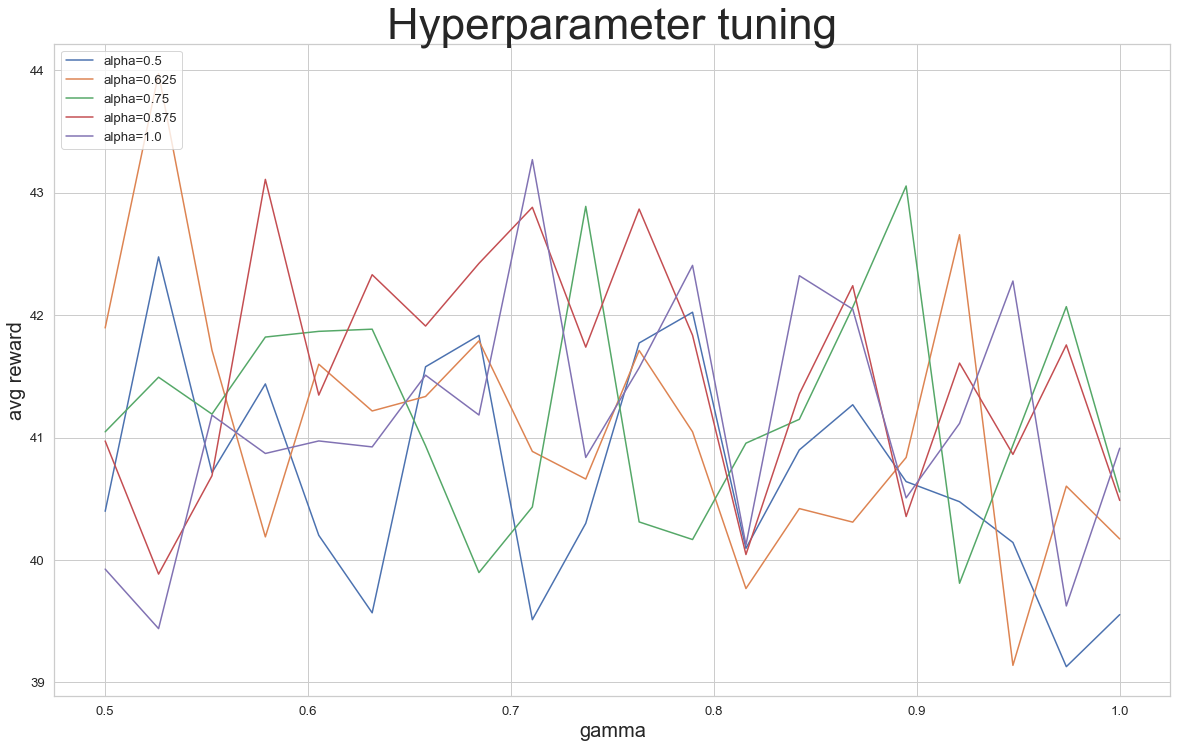

In [25]:
def tune_hyperparameter(learning_rate_list, gamma_list, decay_rate=0.0001, total_episodes=30000, type_='q-learning'):
    reward_list = list()
    env = gym.make('CustomCab-v0')
    best_gamma = None
    best_learning_rate = None

    for learning_rate in learning_rate_list:
        learning_rate_rewards = list()
        for gamma in tqdm(gamma_list):
            if type_ == 'q-learning':
                agent = Q_LearningAgent(env.observation_space.n, env.action_space.n, decay_rate=decay_rate, learning_rate=learning_rate, gamma=gamma)
            else:
                agent = Q_LearningAgent(env.observation_space.n, env.action_space.n, decay_rate=decay_rate, learning_rate=learning_rate, gamma=gamma)
            agent.train(env, total_episodes, show_progress=False)
            q_eval_rewards, q_frames = agent.evaluate(env, total_test_episodes=100, show_progress=False)
            learning_rate_rewards.append(np.mean(q_eval_rewards))
        reward_list.append(learning_rate_rewards)

        plt.plot(gamma_list, learning_rate_rewards, label=f'aplha={learning_rate}')

    plt.legend([f'alpha={x}' for x in learning_rate_list], loc='upper left')
    plt.title('Hyperparameter tuning', fontsize=44)
    plt.ylabel('avg reward', fontsize=20)
    plt.xlabel('gamma', fontsize=20)
    plt.show()
    plt.show()
    return best_gamma, best_learning_rate

gamma_list = np.linspace(0.5,1,20)
learning_rate_list = np.linspace(0.5,1,5)
best_gamma, best_learning_rate = tune_hyperparameter(learning_rate_list, gamma_list, decay_rate=0.0001, total_episodes=30000, type_='q-learning')


# Training

In [10]:
total_episodes = 50000
total_test_episodes = 10

q_agent = Q_LearningAgent(env.observation_space.n, env.action_space.n)
sarsa_agent = SARSA_Agent(env.observation_space.n, env.action_space.n)

## Training Q-learning

In [11]:
q_rewards = q_agent.train(env, total_episodes)

  0%|          | 0/50000 [00:00<?, ?it/s]

## Training SARSA 

In [12]:
sarsa_rewards = sarsa_agent.train(env, total_episodes)

  0%|          | 0/50000 [00:00<?, ?it/s]

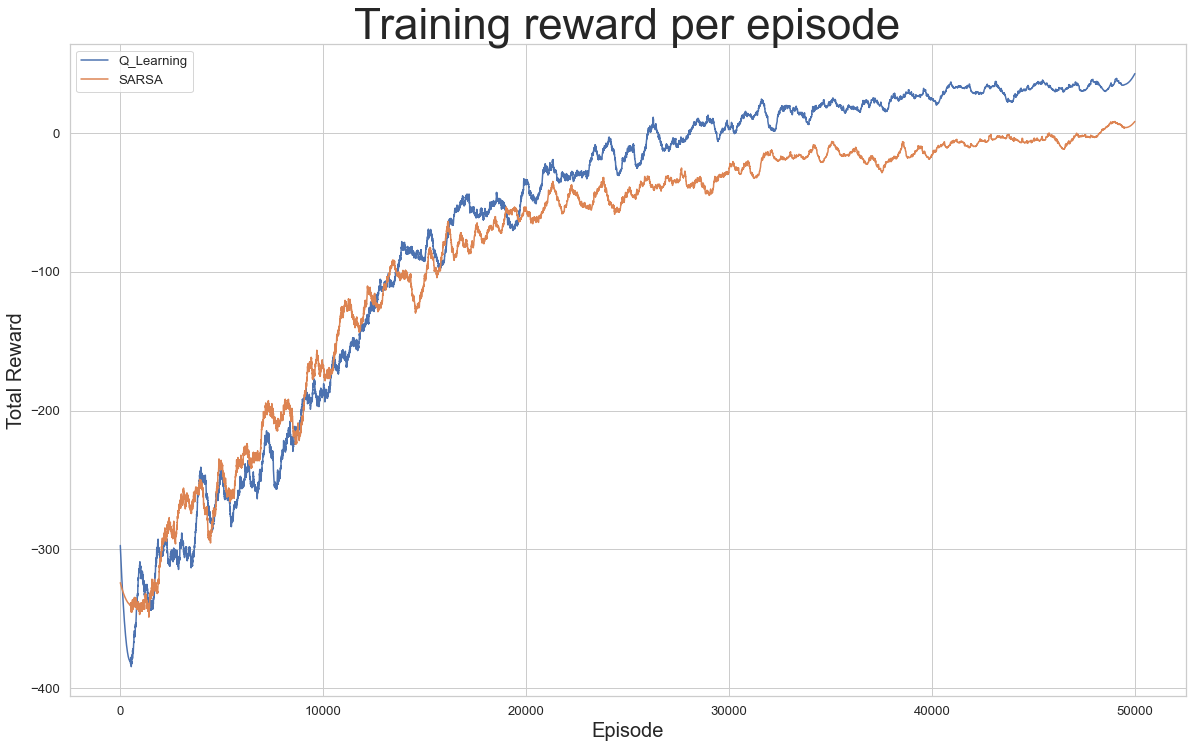

In [15]:
plt.plot(savgol_filter(q_rewards, 1003, 2))
plt.plot(savgol_filter(sarsa_rewards, 1003, 2))
plt.legend(['Q_Learning', 'SARSA'])
plt.title("Training reward per episode", fontsize=44)
plt.xlabel('Episode', fontsize=20);
plt.ylabel('Total Reward', fontsize=20);

Text(0.5, 1.0, 'Epsilon Vs Episodes Trend ')

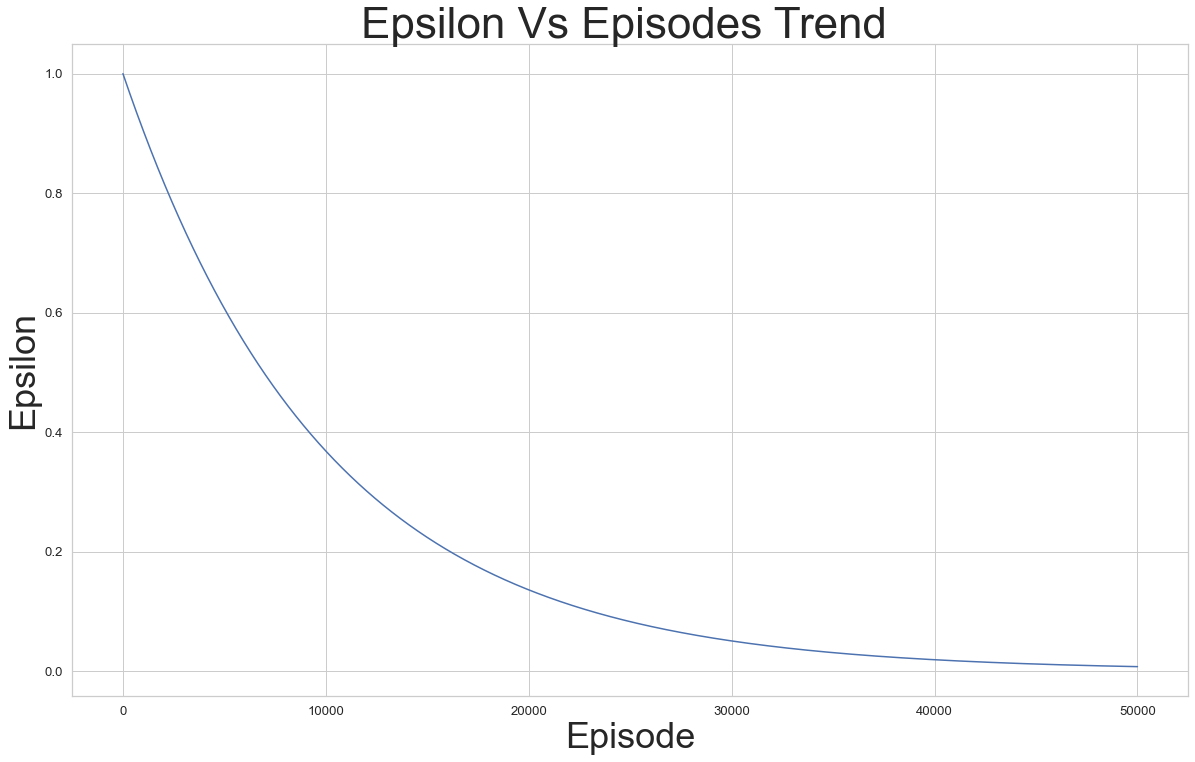

In [16]:
plt.plot(sarsa_agent.epsilons_)
plt.xlabel('Episode', fontsize=36);
plt.ylabel('Epsilon', fontsize=36);
plt.title("Epsilon Vs Episodes Trend ", fontdict={'fontsize':44})

# Evaluation

In [17]:
# random agent
untrained_frames = list()

for i, episode in enumerate(range(total_test_episodes)):
    step = 1
    state = env.reset()

    while True:
        new_state, reward, done, info = env.step(q_agent.choose_action(state))        
        untrained_frames.append({
          'frame': env.render(mode='ansi'), 'state': state,
          'episode': episode + 1, 'step': step, 'reward': reward
        })
        if done:
            step = 0
            break
        step += 1
        state = new_state
show_frames(untrained_frames)

+-----------------+
|R: :X: : : :X: :G|
| : : : :X: : : : |
|X:X: : :X: : :X:X|
| : : : : : : : : |
| :X:X: : : :X:X: |
| : : : : : : : : |
| : : : :X: : : : |
| : : : :X: : : : |
|Y: :X: : : :X: :B|
+-----------------+
  (Dropoff)

Episode: 100
Timestep: 30
State: 1458
Reward: 1000


In [18]:
#Qlearning
q_eval_rewards, q_frames = q_agent.evaluate(env, total_test_episodes)

  0%|          | 0/100 [00:00<?, ?it/s]

In [19]:
show_frames(q_frames)

+-----------------+
|R: :X: : : :X: :G|
| : : : :X: : : : |
|X:X: : :X: : :X:X|
| : : : : : : : : |
| :X:X: : : :X:X: |
| : : : : : : : : |
| : : : :X: : : : |
| : : : :X: : : : |
|Y: :X: : : :X: :B|
+-----------------+
  (Dropoff)

Episode: 100
Timestep: 27
State: 177
Reward: 1000


In [20]:
#SARSA
sarsa_eval_rewards, sarsa_frames = sarsa_agent.evaluate(env, total_test_episodes)

  0%|          | 0/100 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
plt.plot(q_eval_rewards)
plt.plot(sarsa_eval_rewards)
plt.title("Test Rewards")
plt.legend(['Q_Learning', 'SARSA'])
plt.ylim((-150, 150))
plt.xlabel('Episode Number');
plt.ylabel('Total Reward');

In [ ]:
end_time = time.time()
print(end_time-start_time)